__NOTE: This is a revised version of [geospatial-mapping-example.ipynb](./geospatial-mapping-example.ipynb) and adds a bit of clean up in the dataset.__

# Geospatial Mapping Example [![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sagecontinuum/sage-data-client/blob/main/examples/contrib/geospatial_mapping_example_v2.ipynb)
Within this example, we walk through how to query for SAGE data, filter our values, and plot maps of the data using Cartopy, Matplotlib, and hvPlot!







## Imports
We import our sage_data_client, along with the plotting libraries matplotlib, Cartopy, hvPlot and holoviews.

If you have not installed these packages already, make sure to run this line!

__NOTE: Newer pip will ask you to put the `--break-system-packages` option in the install command. If you do not want to do so, please follow their guidance that will appear in the terminal after running the command WITHOUT the option.__

In [1]:
!pip3 install \
    sage_data_client \
    matplotlib \
    bokeh \
    holoviews \
    hvplot \
    cartopy \
    pandas \
    metpy \
    geoviews \
    --break-system-packages


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import sage_data_client
from bokeh.models.formatters import DatetimeTickFormatter
import hvplot.pandas
import holoviews as hv
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.plots import USCOUNTIES
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
hv.extension("bokeh")

# Query and load data into pandas data frame
We have two queries we are interested in:
- Temperature
- Location data (latitude and longitude of the sensor)

In [3]:
temperature_df = sage_data_client.query(
    start="-3h",
    filter={
        "name": "env.temperature",
        "sensor": "bme680",
        "zone": "shield",
    }
)

location_df = sage_data_client.query(
    start="-3h",
    filter={
        "name": "sys.gps.*",
    }
)



> NOTE: The filter specifies the bme680 sensor from the compute zone "shield". This allows us to pull only the temperature data of the local environment. We have up to 3 different temperature sensors in Waggle/Sage nodes, measuring: inside the compute box, the local environment, and a box hosting scientific instruments.



### Investigate the Temperature Dataframe
Notice how the dataframe containing temperature data stores the temperature value as `value`, along with several `meta.` fields.

In [4]:
temperature_df

,timestamp,name,value,meta.host,meta.job,meta.node,meta.plugin,meta.sensor,meta.task,meta.vsn,meta.zone
0,2024-09-18 18:18:03.550330543+00:00,env.temperature,32.27,0000d83add0dbcb6.ws-rpi,Pluginctl,000048b02dd3c42d,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W0AF,shield
1,2024-09-18 18:18:33.564646354+00:00,env.temperature,32.19,0000d83add0dbcb6.ws-rpi,Pluginctl,000048b02dd3c42d,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W0AF,shield
2,2024-09-18 18:19:03.570814980+00:00,env.temperature,32.18,0000d83add0dbcb6.ws-rpi,Pluginctl,000048b02dd3c42d,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W0AF,shield
3,2024-09-18 18:19:33.589087043+00:00,env.temperature,32.16,0000d83add0dbcb6.ws-rpi,Pluginctl,000048b02dd3c42d,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W0AF,shield
4,2024-09-18 18:20:03.613361207+00:00,env.temperature,32.15,0000d83add0dbcb6.ws-rpi,Pluginctl,000048b02dd3c42d,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W0AF,shield
...,...,...,...,...,...,...,...,...,...,...,...
13308,2024-09-18 21:15:29.541816890+00:00,env.temperature,23.74,0000e45f014524c6.ws-rpi,Pluginctl,000048b02d3af476,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W051,shield
13309,2024-09-18 21:15:59.573379804+00:00,env.temperature,23.73,0000e45f014524c6.ws-rpi,Pluginctl,000048b02d3af476,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W051,shield
13310,2024-09-18 21:16:29.583534221+00:00,env.temperature,23.73,0000e45f014524c6.ws-rpi,Pluginctl,000048b02d3af476,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W051,shield
13311,2024-09-18 21:16:59.586776078+00:00,env.temperature,23.73,0000e45f014524c6.ws-rpi,Pluginctl,000048b02d3af476,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W051,shield


### Investigate the Location Dataframe
This dataframe does not have as many metadata fields... but we do have enough to join our two dataframes. Another issue with this dataframe is that the location values are stored as individual rows, when we would ideally like these to be their own columns (ex. latitude and longitude for a given location)

In [5]:
location_df

,timestamp,name,value,meta.host,meta.node,meta.vsn
0,2024-09-18 18:29:25.280659275+00:00,sys.gps.alt,190.764,000048b02d05a1c2.ws-nxcore,000048b02d05a1c2,W02C
1,2024-09-18 18:31:27.111297782+00:00,sys.gps.alt,171.553,000048b02d05a1c2.ws-nxcore,000048b02d05a1c2,W02C
2,2024-09-18 18:35:26.047160117+00:00,sys.gps.alt,151.632,000048b02d05a1c2.ws-nxcore,000048b02d05a1c2,W02C
3,2024-09-18 18:37:25.775179383+00:00,sys.gps.alt,103.129,000048b02d05a1c2.ws-nxcore,000048b02d05a1c2,W02C
4,2024-09-18 18:41:26.141633948+00:00,sys.gps.alt,153.310,000048b02d05a1c2.ws-nxcore,000048b02d05a1c2,W02C
...,...,...,...,...,...,...
39524,2024-09-18 21:08:59.406405476+00:00,sys.gps.satellites,7.000,000048b02dd3c814.ws-nxcore,000048b02dd3c814,W0B3
39525,2024-09-18 21:10:58.583816334+00:00,sys.gps.satellites,8.000,000048b02dd3c814.ws-nxcore,000048b02dd3c814,W0B3
39526,2024-09-18 21:12:59.601183149+00:00,sys.gps.satellites,8.000,000048b02dd3c814.ws-nxcore,000048b02dd3c814,W0B3
39527,2024-09-18 21:14:58.708038053+00:00,sys.gps.satellites,7.000,000048b02dd3c814.ws-nxcore,000048b02dd3c814,W0B3


## Clean Up the Data

Let's start the data cleaning process!

### Drop Outliers in the Temperature Values
Some nodes often fail to initialize the temperature sensor, causing the sensor to read the temperature way outside the expected range, e.g. -130C. While it needs an effort to fix, we simply ignore those outliers.

In [6]:
# A reasonable degree C can act as a threshold in order to drop outliers. We choose -50C
temperature_df_cleaned = temperature_df[temperature_df["value"] > -50]

### Join Latitude and Longitude into the Same Rows
Our first step is to join our latitude and longitude values into the same row. We start by
- Subsetting for latitude and longitude in the dataframe
- Rename the fields accordingly
- Join the columns based on the timestamp, host, and node
- Drop any extra columns

In [7]:
# Subset the latitude values, and rename to latitude
lat = location_df.loc[location_df.name == 'sys.gps.lat']
lat_df = lat.rename(columns={'value':'latitude'})

# Subset the longitude values, and rename to latitude
lon = location_df.loc[location_df.name == 'sys.gps.lon']
lon_df = lon.rename(columns={'value':'longitude'})

# Join the latitude and longitude dataframes, returning a dataframe with shared latitude and longitude information
joined_lats_lons = pd.merge(lat_df, lon_df, on=['timestamp', 'meta.node'],  how='outer', )

# Filter out unwanted columns
joined_lats_lons = joined_lats_lons[[x for x in joined_lats_lons.columns if (('x' not in x) and ('y' not in x) and ('timestamp' not in x))]]

# Return our dataframe
joined_lats_lons

,latitude,meta.node,longitude
0,30.314363,000048b02d15bc4c,-97.899526
1,41.831047,000048b02d3ae33d,-87.617164
2,41.880638,000048b02d15bc65,-87.745406
3,41.719957,000048b02d35a87e,-87.612794
4,41.869392,000048b02dd3c543,-87.645879
...,...,...,...
4542,41.701372,000048b02dd3c64a,-87.995621
4543,41.701408,000048b02dd3c5e0,-87.995583
4544,41.813917,000048b02dd3c5b3,-87.747555
4545,41.879610,000048b02d05a1c2,-87.624993


### Join our Latitude and Longitude Information with the Temperature Dataframe
Now that we have our location dataframe cleaned up, we can join this with the temperature dataframe, so we know where our temperature values are collected!

In [8]:
# Merge the dataframes using the host and node as the shared fields to join on
df = pd.merge(temperature_df_cleaned, joined_lats_lons,  on='meta.node', how='right')

# Drop any duplicates, based on the timestamp and node
df_filtered = df.drop_duplicates(['timestamp', 'meta.node']).dropna()

In [9]:
df_filtered

,timestamp,name,value,meta.host,meta.job,meta.node,meta.plugin,meta.sensor,meta.task,meta.vsn,meta.zone,latitude,longitude
0,2024-09-18 18:17:52.446481797+00:00,env.temperature,35.93,0000dca632a30639.ws-rpi,Pluginctl,000048b02d15bc4c,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W017,shield,30.314363,-97.899526
1,2024-09-18 18:18:22.482114418+00:00,env.temperature,35.95,0000dca632a30639.ws-rpi,Pluginctl,000048b02d15bc4c,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W017,shield,30.314363,-97.899526
2,2024-09-18 18:18:52.515117453+00:00,env.temperature,35.96,0000dca632a30639.ws-rpi,Pluginctl,000048b02d15bc4c,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W017,shield,30.314363,-97.899526
3,2024-09-18 18:19:22.527199663+00:00,env.temperature,35.97,0000dca632a30639.ws-rpi,Pluginctl,000048b02d15bc4c,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W017,shield,30.314363,-97.899526
4,2024-09-18 18:19:52.530534334+00:00,env.temperature,35.97,0000dca632a30639.ws-rpi,Pluginctl,000048b02d15bc4c,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W017,shield,30.314363,-97.899526
...,...,...,...,...,...,...,...,...,...,...,...,...,...
328947,2024-09-18 21:15:11.232663088+00:00,env.temperature,32.95,0000d83add0dbcb6.ws-rpi,Pluginctl,000048b02dd3c42d,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W0AF,shield,41.701335,-87.995605
328948,2024-09-18 21:15:41.263576053+00:00,env.temperature,33.00,0000d83add0dbcb6.ws-rpi,Pluginctl,000048b02dd3c42d,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W0AF,shield,41.701335,-87.995605
328949,2024-09-18 21:16:11.293708361+00:00,env.temperature,33.04,0000d83add0dbcb6.ws-rpi,Pluginctl,000048b02dd3c42d,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W0AF,shield,41.701335,-87.995605
328950,2024-09-18 21:16:41.313818998+00:00,env.temperature,33.06,0000d83add0dbcb6.ws-rpi,Pluginctl,000048b02dd3c42d,waggle/plugin-iio:0.7.0,bme680,wes-iio-bme680,W0AF,shield,41.701335,-87.995605


## Run Statistics on our Dataframe
Let's say we are interested in hourly mean temperature... we can calculate that!

In [10]:
hours = df_filtered.timestamp.dt.hour.unique()

In [11]:
hourly_mean = df_filtered.groupby([df_filtered.timestamp.dt.hour,
                                   'meta.node'])[["value", "longitude", "latitude"]].mean()

In [12]:
hourly_mean

value  longitude   latitude
timestamp meta.node                                        
18        000048b02d05a1c7  28.938941 -87.630420  41.883601
          000048b02d15bc4c  36.146118 -97.899526  30.314363
          000048b02d15bc65  33.995059 -87.745406  41.880638
          000048b02d15bc6d  31.451647 -90.086082  40.350654
          000048b02d15bc7c  32.860000 -87.978578  41.717853
...                               ...        ...        ...
21        000048b02dd3c644  32.858889 -87.995640  41.701356
          000048b02dd3c6cf  33.465556 -87.995597  41.701349
          000048b02dd3c6f0  32.542286 -87.995482  41.701335
          000048b02dd3c722  32.557429 -87.995552  41.701352
          000048b02dd3c814  32.232571 -87.995526  41.701278

[108 rows x 3 columns]

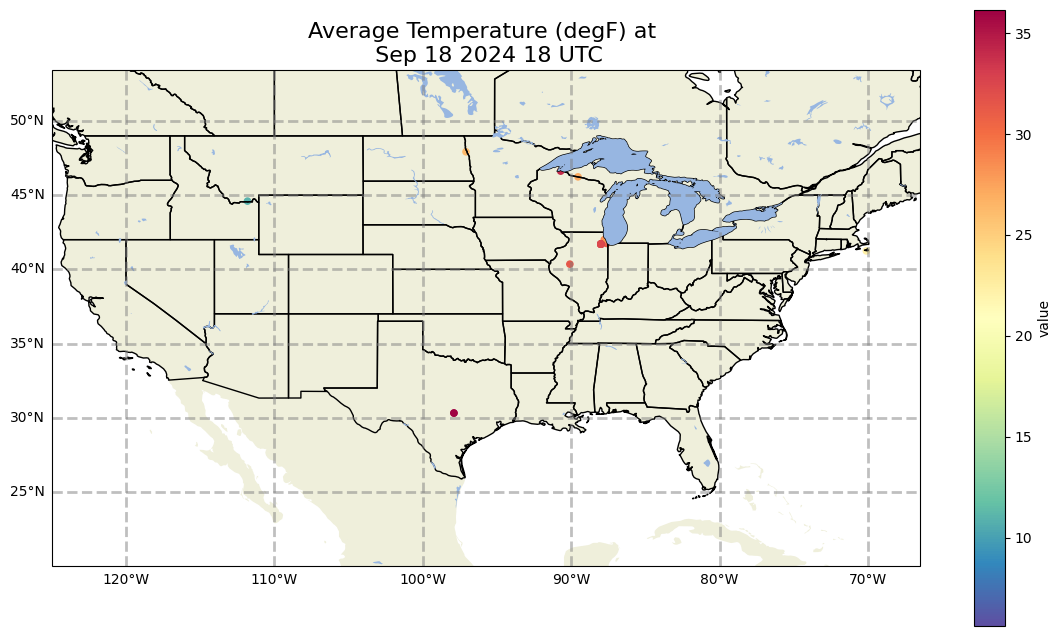

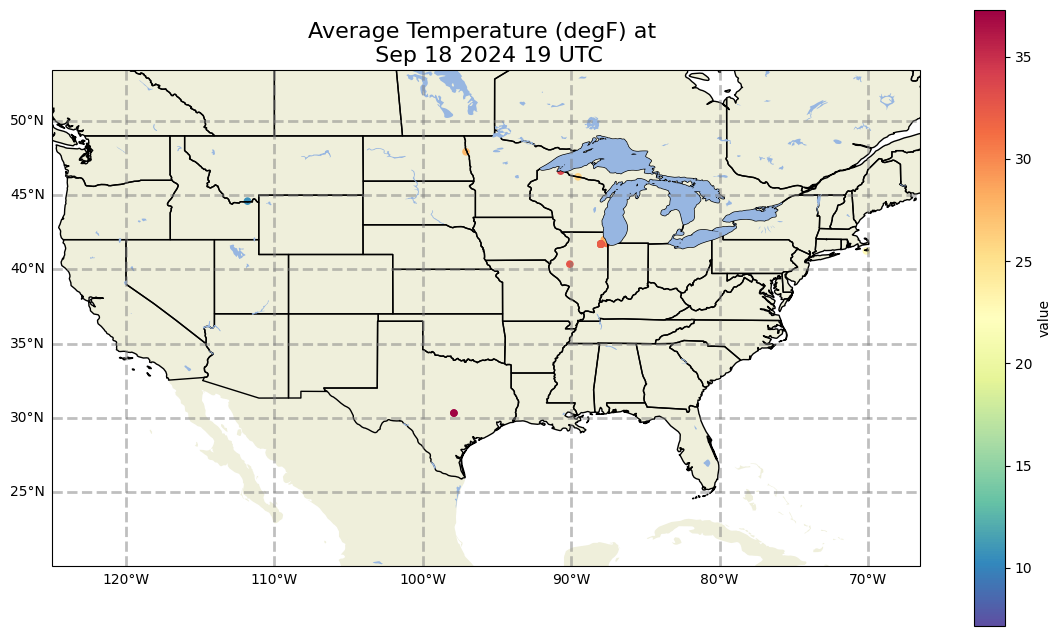

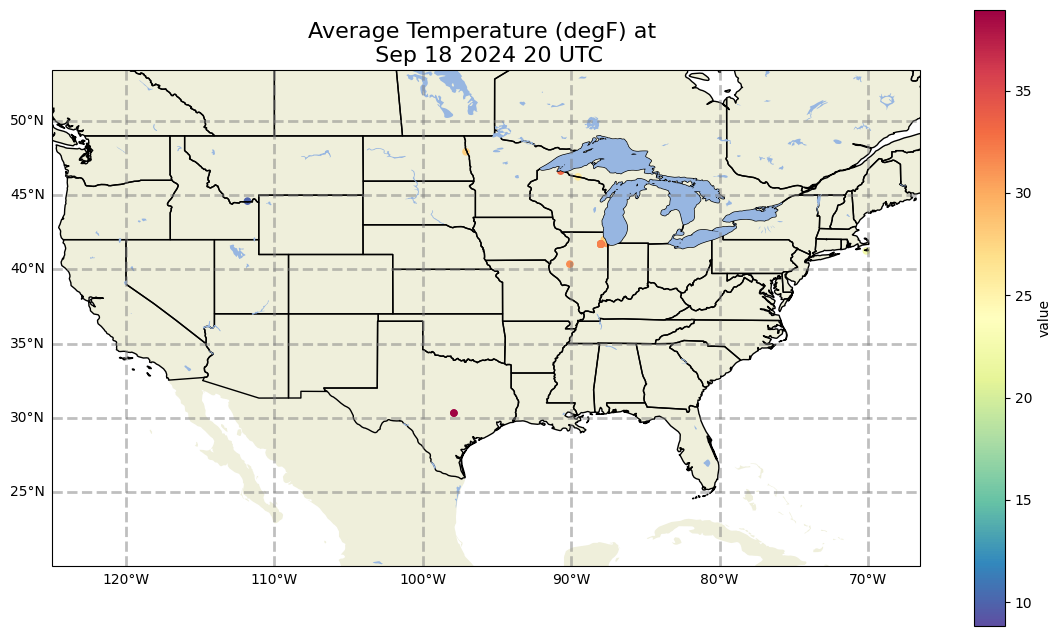

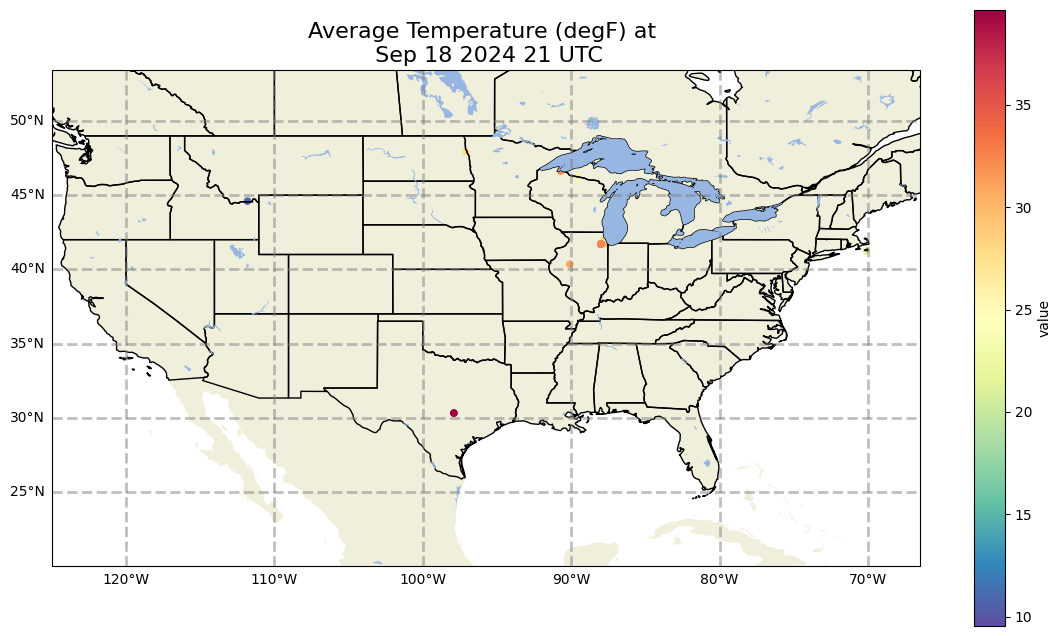

In [13]:
for hour in hours:
    fig = plt.figure(figsize=(14,8))
    ax = plt.subplot(projection=ccrs.PlateCarree())
    s = hourly_mean.loc[hour].plot.scatter(ax=ax, x='longitude', y='latitude', c='value', cmap='Spectral_r')
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.LAKES)
    ax.set_extent([-125, -66.5, 20, 50])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    time_label = df_filtered.timestamp.min().strftime(f'%b %d %Y {hour} UTC')
    plt.title(f'Average Temperature (degF) at \n {time_label}', fontsize=16);
    plt.show()
    plt.close()

### Zoom in on the Chicago Area
It's nice having a national map, but let's zoom into Chicago for a higher resolution view of the sensors around the city and surrounding suburbs.

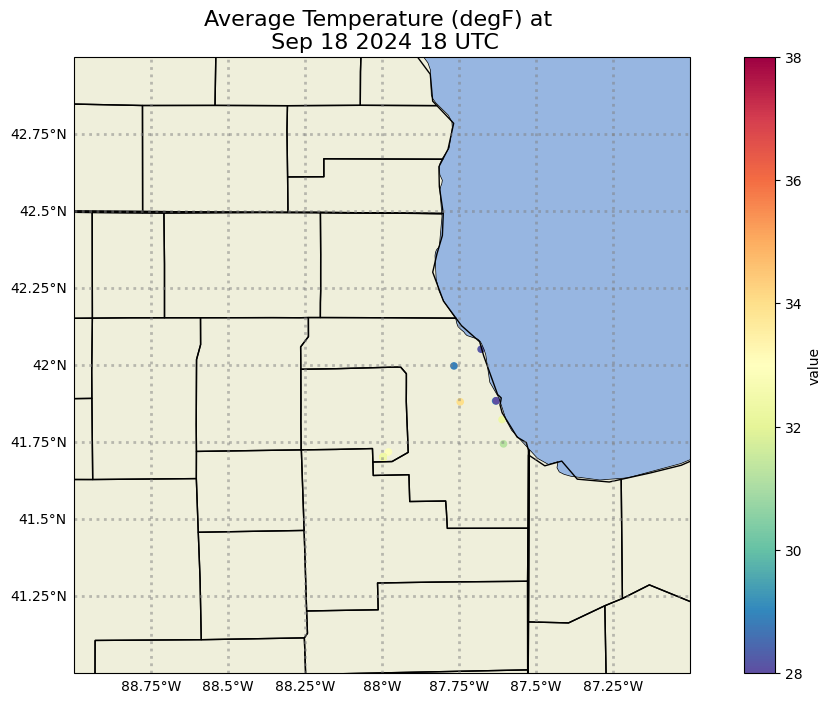

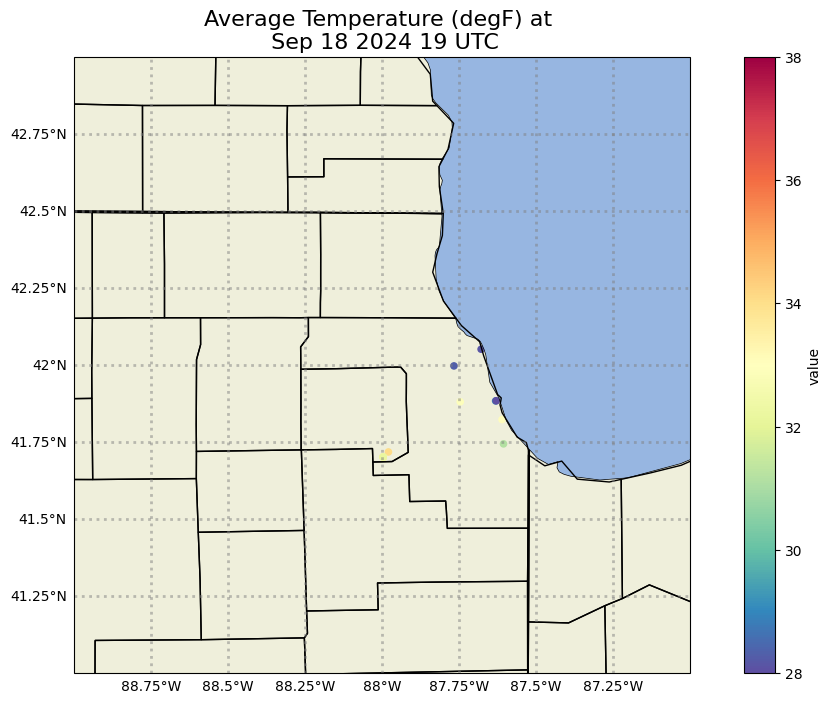

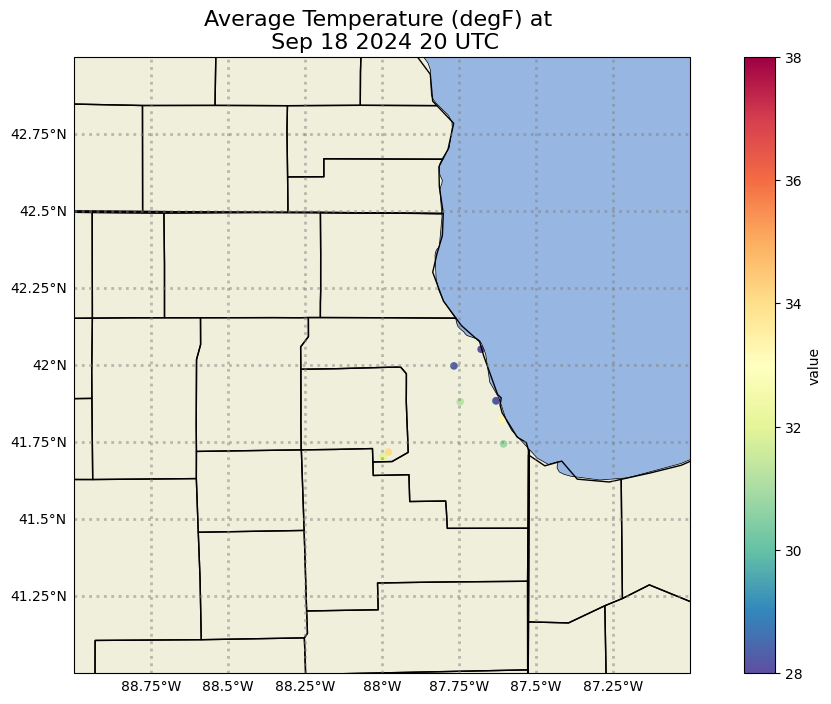

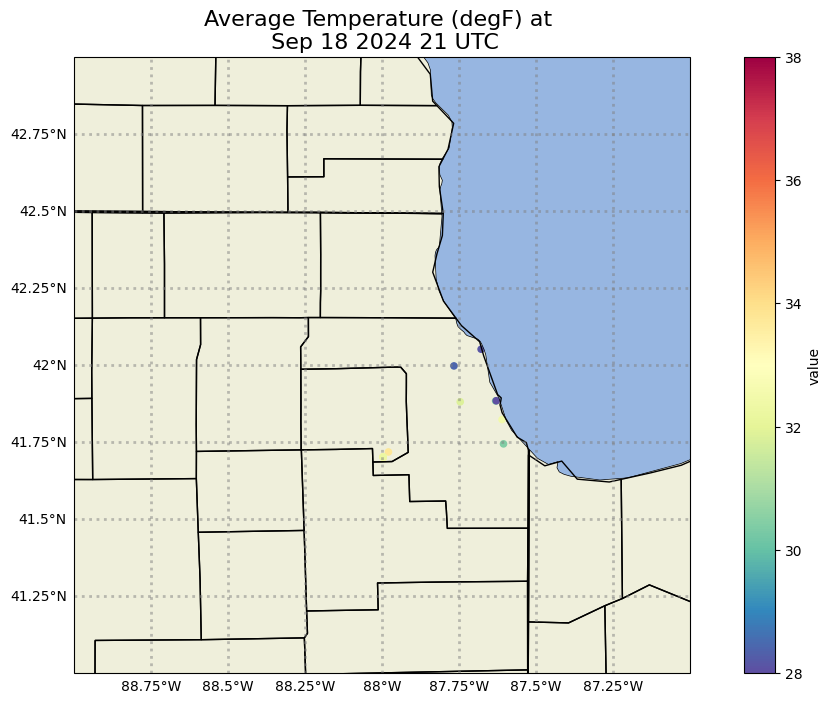

In [14]:
for hour in hours:
    fig = plt.figure(figsize=(14,8))
    ax = plt.subplot(projection=ccrs.PlateCarree())
    s = hourly_mean.loc[hour].plot.scatter(ax=ax, x='longitude', y='latitude', c='value', cmap='Spectral_r', vmin=28, vmax=38)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(USCOUNTIES)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle=':')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent([-89, -87, 41, 43])
    time_label = df_filtered.timestamp.min().strftime(f'%b %d %Y {hour} UTC')
    plt.title(f'Average Temperature (degF) at \n {time_label}', fontsize=16);
    plt.show()
    plt.close()

### Plot Interactive National Maps
We can use hvPlot here to plot interactive national maps

In [15]:
for hour in hours:
    time_label = df_filtered.timestamp.min().strftime(f'%b %d %Y {hour} UTC')
    display(hourly_mean.loc[hour].hvplot.points(x='longitude',
                                                y='latitude',
                                                color='value',
                                                cmap='Spectral_r',
                                                geo=True,
                                                tiles='CartoLight',
                                                title=f'Average Temperature (degF) at {time_label}',
                                                clabel='Temperature (degF)',
                                                crs=ccrs.PlateCarree()))

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (value)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (value)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (value)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (value)

### Plot an Interactive Regional Map of Chicago
And the same for the region around Chicago

We start first by subsetting points out of our dataframe around the Northern Illinois area.

In [16]:
illinois_points = hourly_mean.loc[(hourly_mean.latitude > 38.) & (hourly_mean.latitude < 43.) & (hourly_mean.longitude < -87) & (hourly_mean.longitude > -92)]

Now that we have this, we loop through and plot our data!

In [17]:
for hour in hours:
    time_label = df_filtered.timestamp.min().strftime(f'%b %d %Y {hour} UTC')
    display(illinois_points.loc[hour].hvplot.points(x='longitude',
                                                    y='latitude',
                                                    color='value',
                                                    cmap='Spectral_r',
                                                    tiles='CartoLight',
                                                    geo=True,
                                                    title=f'Average Temperature (degF) at {time_label}',
                                                    clabel='Temperature (degF)'))

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (value)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (value)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (value)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (value)